In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from umap import UMAP
from madrigal.utils import BASE_DIR

OUTPUT_DIR = BASE_DIR + "model_output/"
MODEL_OUTPUT_DIR = OUTPUT_DIR + "pretrain/DrugBank/split_by_drugs_random"

DDI_SOURCE = "DrugBank"
split_method = "split_by_drugs_random"

drug_metadata = pd.read_pickle(BASE_DIR + 'processed_data/views_features_new/combined_metadata_ddi.pkl')
drug_metadata['view_str'] = 1
mod_avail = drug_metadata[['view_str', 'view_kg', 'view_cv', 'view_tx_mcf7', 'view_tx_pc3', 'view_tx_vcap']]
full_modality_drugs = mod_avail[mod_avail.sum(axis=1) == 6].index.values

In [ ]:
# get after encoder
from madrigal.utils import get_model

checkpoint_after_path = "checkpoint_1000.pt"

encoder_after, encoder_configs = get_model(
    all_kg_data=None,
    feature_dim=None,
    prediction_dim=None,
    str_encoder_name=None,
    str_encoder_hparams=None,
    kg_encoder_name=None, 
    kg_encoder_hparams=None, 
    cv_encoder_name=None,
    cv_encoder_hparams=None,
    tx_encoder_name=None,
    tx_encoder_hparams=None,
    num_attention_bottlenecks=2, 
    pos_emb_type="learnable", 
    pos_emb_dropout=0.1, 
    transformer_fusion_hparams=None, 
    proj_hparams=None, 
    fusion=None, 
    normalize=None, 
    decoder_normalize=None, 
    frozen=None, 
    adapt_before_fusion=False,  # these don't matter
    
    checkpoint_path=checkpoint_after_path,
    encoder_only=True, 
    use_modality_pretrain=True,
    use_tx_basal=True,  # THIS MUST ALIGN WITH THE SPECIFIC CL RUN
    use_pretrained_adaptor=True,
    device="cpu",
)

In [ ]:
before_str = torch.load(BASE_DIR+'model_output/pretrain/before_pretrain/train_embeds_0.pt')
before_kg = torch.load(BASE_DIR+'model_output/pretrain/before_pretrain/train_embeds_1.pt')
before_cv = torch.load(BASE_DIR+'model_output/pretrain/before_pretrain/train_embeds_2.pt')
before_tx_mcf7 = torch.load(BASE_DIR+'model_output/pretrain/before_pretrain/train_embeds_13.pt')
before_tx_pc3 = torch.load(BASE_DIR+'model_output/pretrain/before_pretrain/train_embeds_15.pt')
before_tx_vcap = torch.load(BASE_DIR+'model_output/pretrain/before_pretrain/train_embeds_17.pt')

# assert all drugs arrays are sorted
assert np.all(before_str['drugs'][:-1] <= before_str['drugs'][1:])
assert np.all(before_kg['drugs'][:-1] <= before_kg['drugs'][1:])
assert np.all(before_cv['drugs'][:-1] <= before_cv['drugs'][1:])
assert np.all(before_tx_mcf7['drugs'][:-1] <= before_tx_mcf7['drugs'][1:])
assert np.all(before_tx_pc3['drugs'][:-1] <= before_tx_pc3['drugs'][1:])
assert np.all(before_tx_vcap['drugs'][:-1] <= before_tx_vcap['drugs'][1:])

In [ ]:
class Args:
    path_base = BASE_DIR+'processed_data/'
    kg_encoder = 'hgt'
    split_method = split_method
    data_source = 'DrugBank'
    pretrain_mode = 'str_center_uni'
    pretrain_unbalanced = False
    pretrain_tx_downsample_ratio = 1
    extra_str_neg_mol_num = 0
    kg_sampling_num_neighbors = None
    kg_sampling_num_layers = None
    pretrain_batch_size = None
    num_workers = 2
    drop_last = False
    kg_sampling_num_neighbors = None
    kg_sampling_num_layers = None

## UMAP

In [ ]:
def get_pretrain_data(args, hparams):
    """ Get all pretraining data
    NOTE: Pretraining should always be based on split-by-drugs (but random, easy, and hard should be different) -- we use only drugs not in the val/test set (technically we can also include val drugs, but during model development, we don't want to overfit to the val set).  
    """
    from madrigal.data.data import DrugCLCollator, DataLoader, TensorDataset, CELL_LINES
    # load drug metadata, get pretraining drugs (drugs with more than one views available)
    drug_metadata = pd.read_pickle(os.path.join(args.path_base, 'views_features_new/combined_metadata_ddi.pkl'))
    drug_metadata['view_str'] = 1  # all drugs must have structure (filtered already during preprocessing)
    mod_avail_df = drug_metadata[['view_str', 'view_kg', 'view_cv'] + [f'view_tx_{cell_line}' for cell_line in CELL_LINES]]
    pretrain_drugs = mod_avail_df[mod_avail_df.sum(axis=1) >= 2].index.values  # only drugs with at least 2 views are used for pretraining
    test_drugs = None

    all_dataset = TensorDataset(torch.from_numpy(pretrain_drugs))
    
    collator = DrugCLCollator(args.path_base, mod_avail_df, args.kg_encoder, args.kg_sampling_num_neighbors, args.kg_sampling_num_layers, test_drugs)
    pretrain_loader = DataLoader(all_dataset, batch_size=len(all_dataset), shuffle=False, num_workers=args.num_workers, pin_memory=True, drop_last=args.drop_last, collate_fn=collator)
    
    return pretrain_drugs, pretrain_loader


In [ ]:
args = Args()
pretrain_drugs, pretrain_loader = get_pretrain_data(args, None)
data = next(iter(pretrain_loader))
mols, kg, cv, tx_dict = data[1]

In [ ]:
np.random.seed(1)

drugs_of_interest = np.sort(np.random.choice(np.intersect1d(full_modality_drugs, before_str["drugs"]), size=10, replace=False))
drugs_of_interest_new_indices = [np.where(pretrain_drugs == drug)[0][0] for drug in drugs_of_interest]
batch_mols = mols[drugs_of_interest_new_indices]
batch_kg = kg
batch_cv = cv[drugs_of_interest_new_indices]
batch_tx_dict = {cl : {tp: ddt[drugs_of_interest_new_indices] for tp, ddt in dt.items()} for cl, dt in tx_dict.items()}

with torch.no_grad():
    encoder_after.eval()
    
    # str
    batch_masks = torch.tensor([0] + [1]*18).repeat((10,1)).bool()
    samples_after_str_embeds = encoder_after(torch.from_numpy(drugs_of_interest).long(), batch_masks, batch_mols, batch_kg, batch_cv, batch_tx_dict, raw_encoder_output=True).numpy()

    # kg
    batch_masks = torch.tensor([1,0] + [1]*17).repeat((10,1)).bool()
    samples_after_kg_embeds = encoder_after(torch.from_numpy(drugs_of_interest).long(), batch_masks, batch_mols, batch_kg, batch_cv, batch_tx_dict, raw_encoder_output=True).numpy()

    # cv
    batch_masks = torch.tensor([1,1,0] + [1]*16).repeat((10,1)).bool()
    samples_after_cv_embeds = encoder_after(torch.from_numpy(drugs_of_interest).long(), batch_masks, batch_mols, batch_kg, batch_cv, batch_tx_dict, raw_encoder_output=True).numpy()

    # tx_mcf7
    batch_masks = torch.tensor([1]*13 + [0] + [1]*5).repeat((10,1)).bool()
    samples_after_tx_mcf7_embeds = encoder_after(torch.from_numpy(drugs_of_interest).long(), batch_masks, batch_mols, batch_kg, batch_cv, batch_tx_dict, raw_encoder_output=True).numpy()

    # tx_pc3
    batch_masks = torch.tensor([1]*15 + [0] + [1]*3).repeat((10,1)).bool()
    samples_after_tx_pc3_embeds = encoder_after(torch.from_numpy(drugs_of_interest).long(), batch_masks, batch_mols, batch_kg, batch_cv, batch_tx_dict, raw_encoder_output=True).numpy()

    # tx_vcap
    batch_masks = torch.tensor([1]*17 + [0] + [1]*1).repeat((10,1)).bool()
    samples_after_tx_vcap_embeds = encoder_after(torch.from_numpy(drugs_of_interest).long(), batch_masks, batch_mols, batch_kg, batch_cv, batch_tx_dict, raw_encoder_output=True).numpy()

all_samples_after_embeds = np.concatenate([
    samples_after_str_embeds,
    samples_after_kg_embeds,
    samples_after_cv_embeds,
    samples_after_tx_mcf7_embeds,
    samples_after_tx_pc3_embeds,
    samples_after_tx_vcap_embeds,
], axis=0)
umap_after = UMAP().fit_transform(all_samples_after_embeds)

drug_labels = np.tile([drug_metadata["node_name"].dropna().to_dict()[drug_ind] for drug_ind in drugs_of_interest], 6).astype(str)
modality_labels = np.repeat(np.array(['Structure', 'Pathways', 'Cell viability', 'Transcriptomics (MCF7)', 'Transcriptomics (PC3)', 'Transcriptomics (VCAP)']), 10)

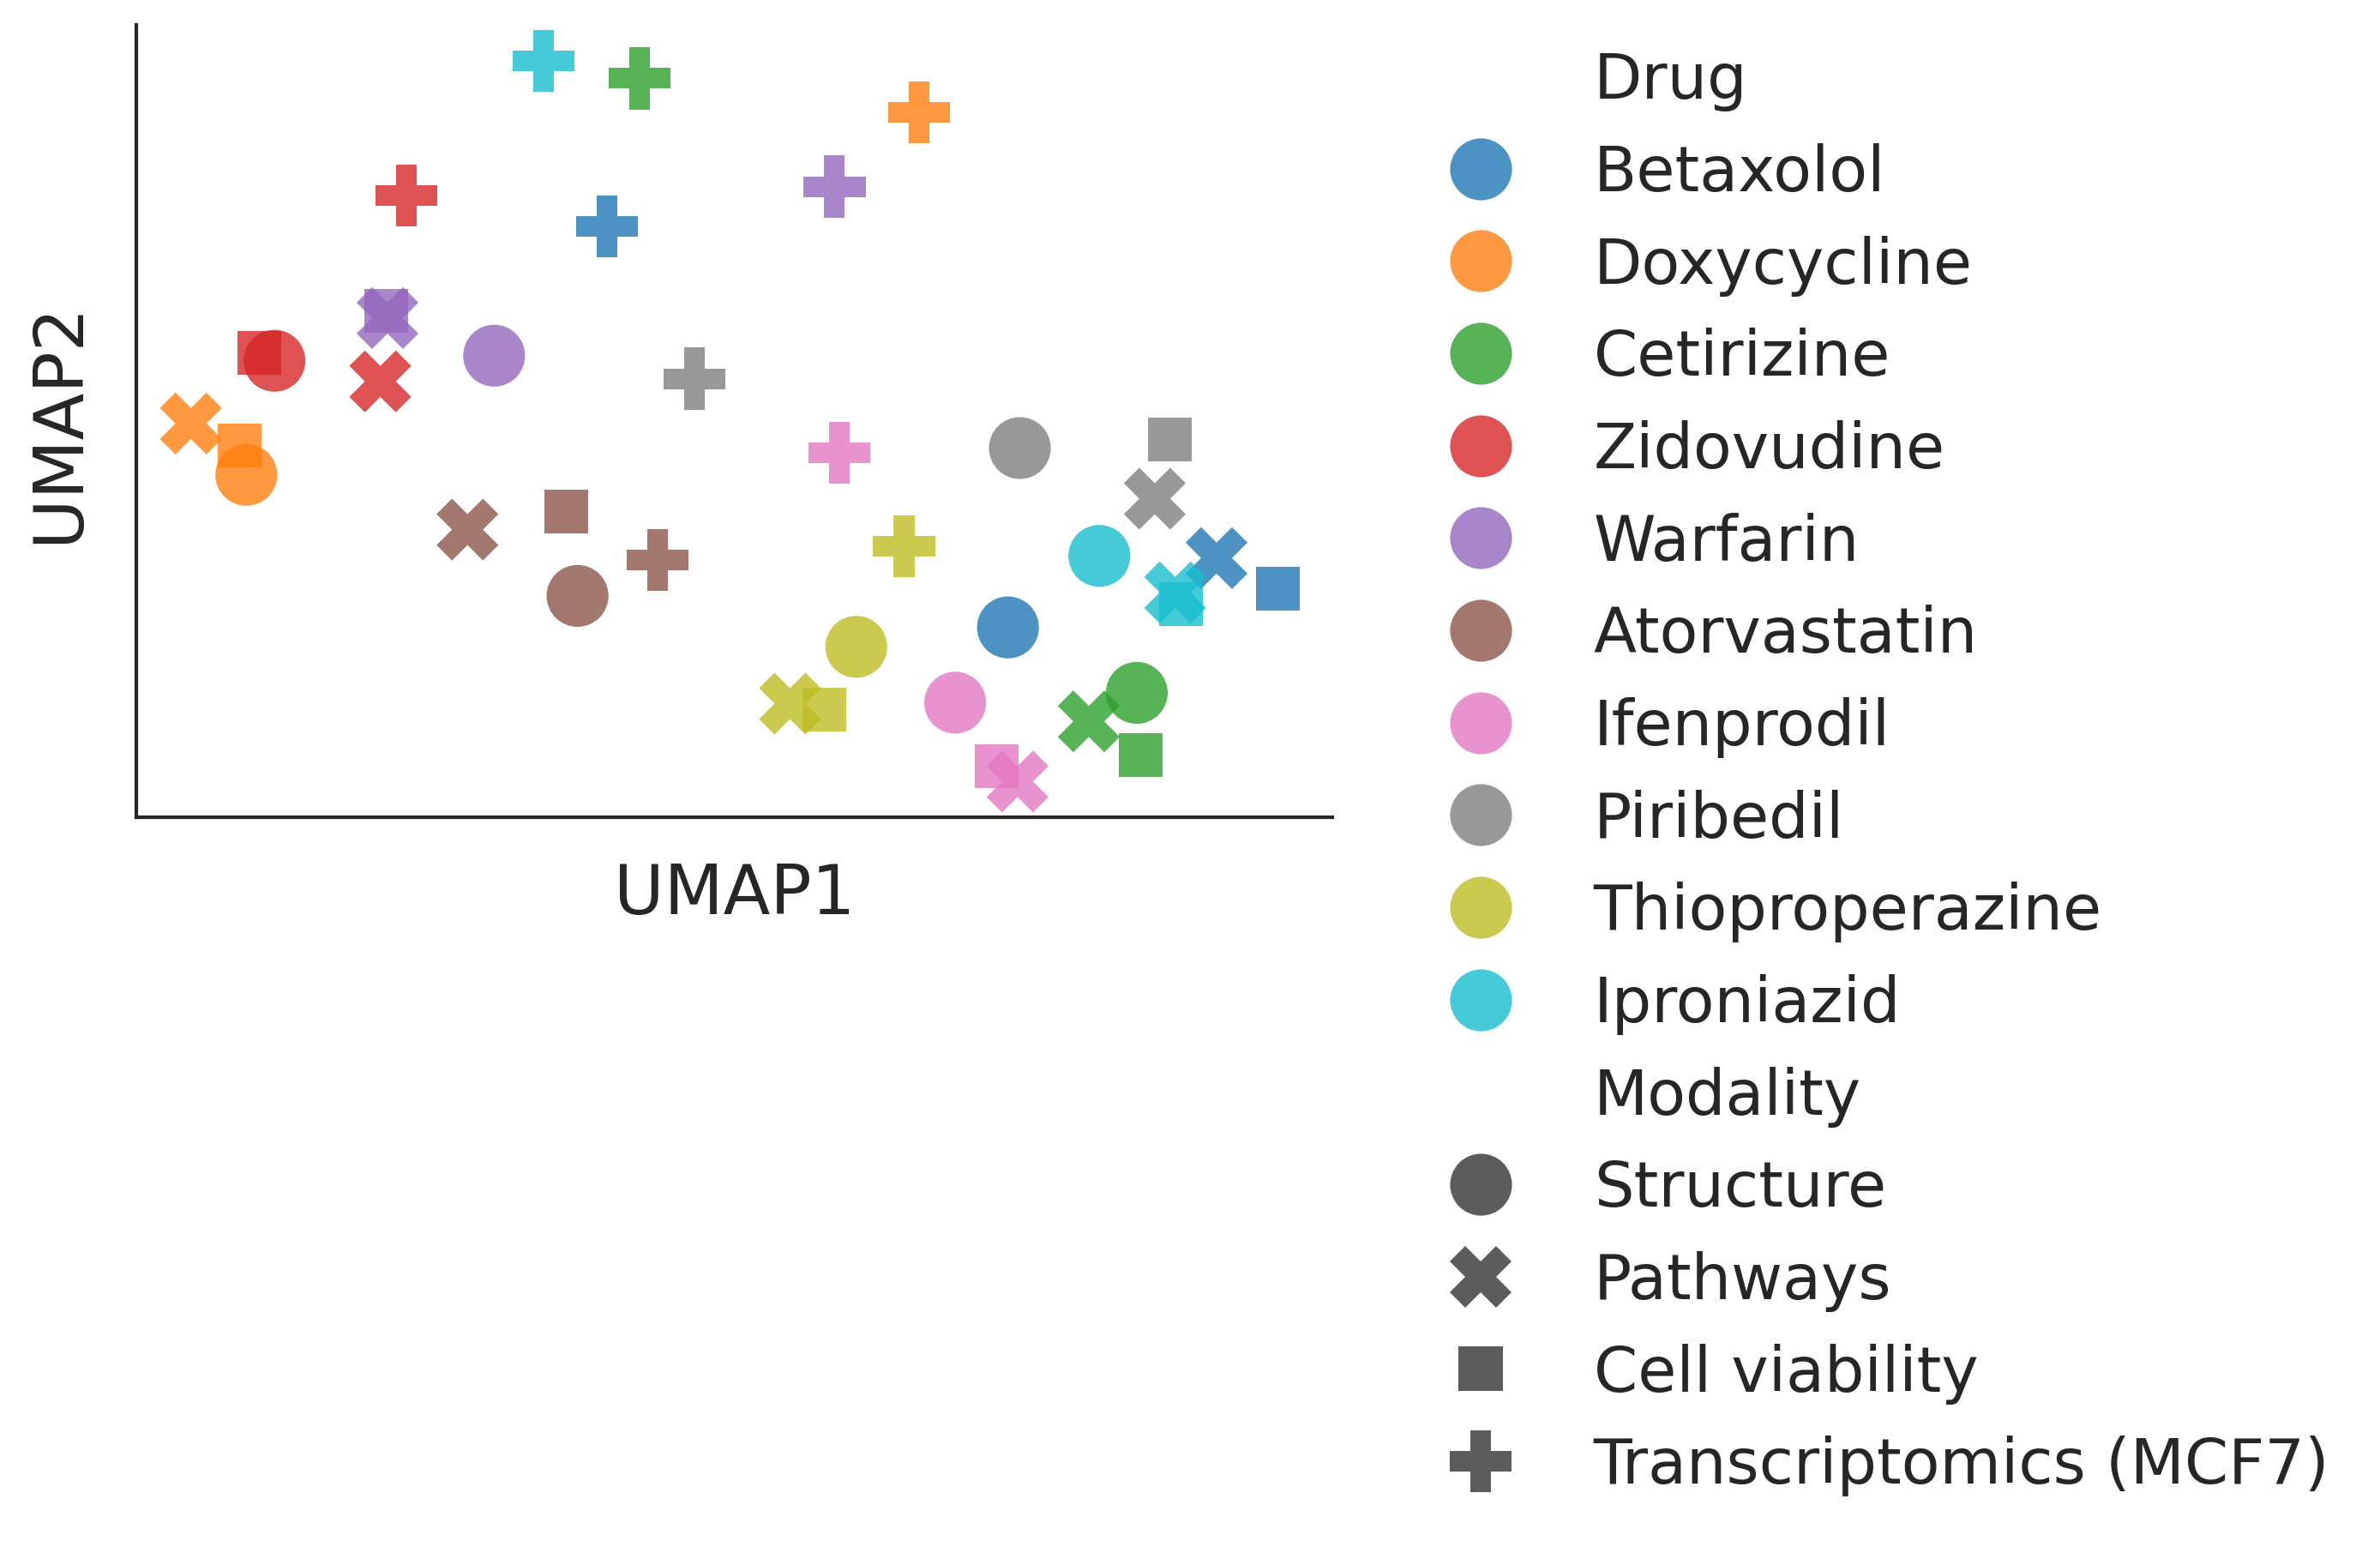

In [ ]:
%matplotlib inline

# Create a DataFrame with umap_before, modality_labels, and drug_labels
plot_data = pd.DataFrame(umap_after, columns=['UMAP1', 'UMAP2'])
plot_data['Modality'] = modality_labels
plot_data['Drug'] = drug_labels

# Create scatter plot using seaborn
plt.figure(figsize=(6, 4), dpi=300)
sns.set(context="paper", style="white", font_scale=2)
scatter_plot = sns.scatterplot(data=plot_data[plot_data["Modality"].isin(['Structure', 'Pathways', 'Cell viability', 'Transcriptomics (MCF7)'])], 
                               x='UMAP1', y='UMAP2', hue='Drug', style='Modality', alpha=.8, s=300, linewidth=0, palette="tab10")

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False, ncols=1)
scatter_plot.set(xticklabels=[])
scatter_plot.set(yticklabels=[])
sns.despine()

plt.savefig("./fig1_drug_embeds_after_pretrain.svg", dpi=300, format="svg")
plt.show()

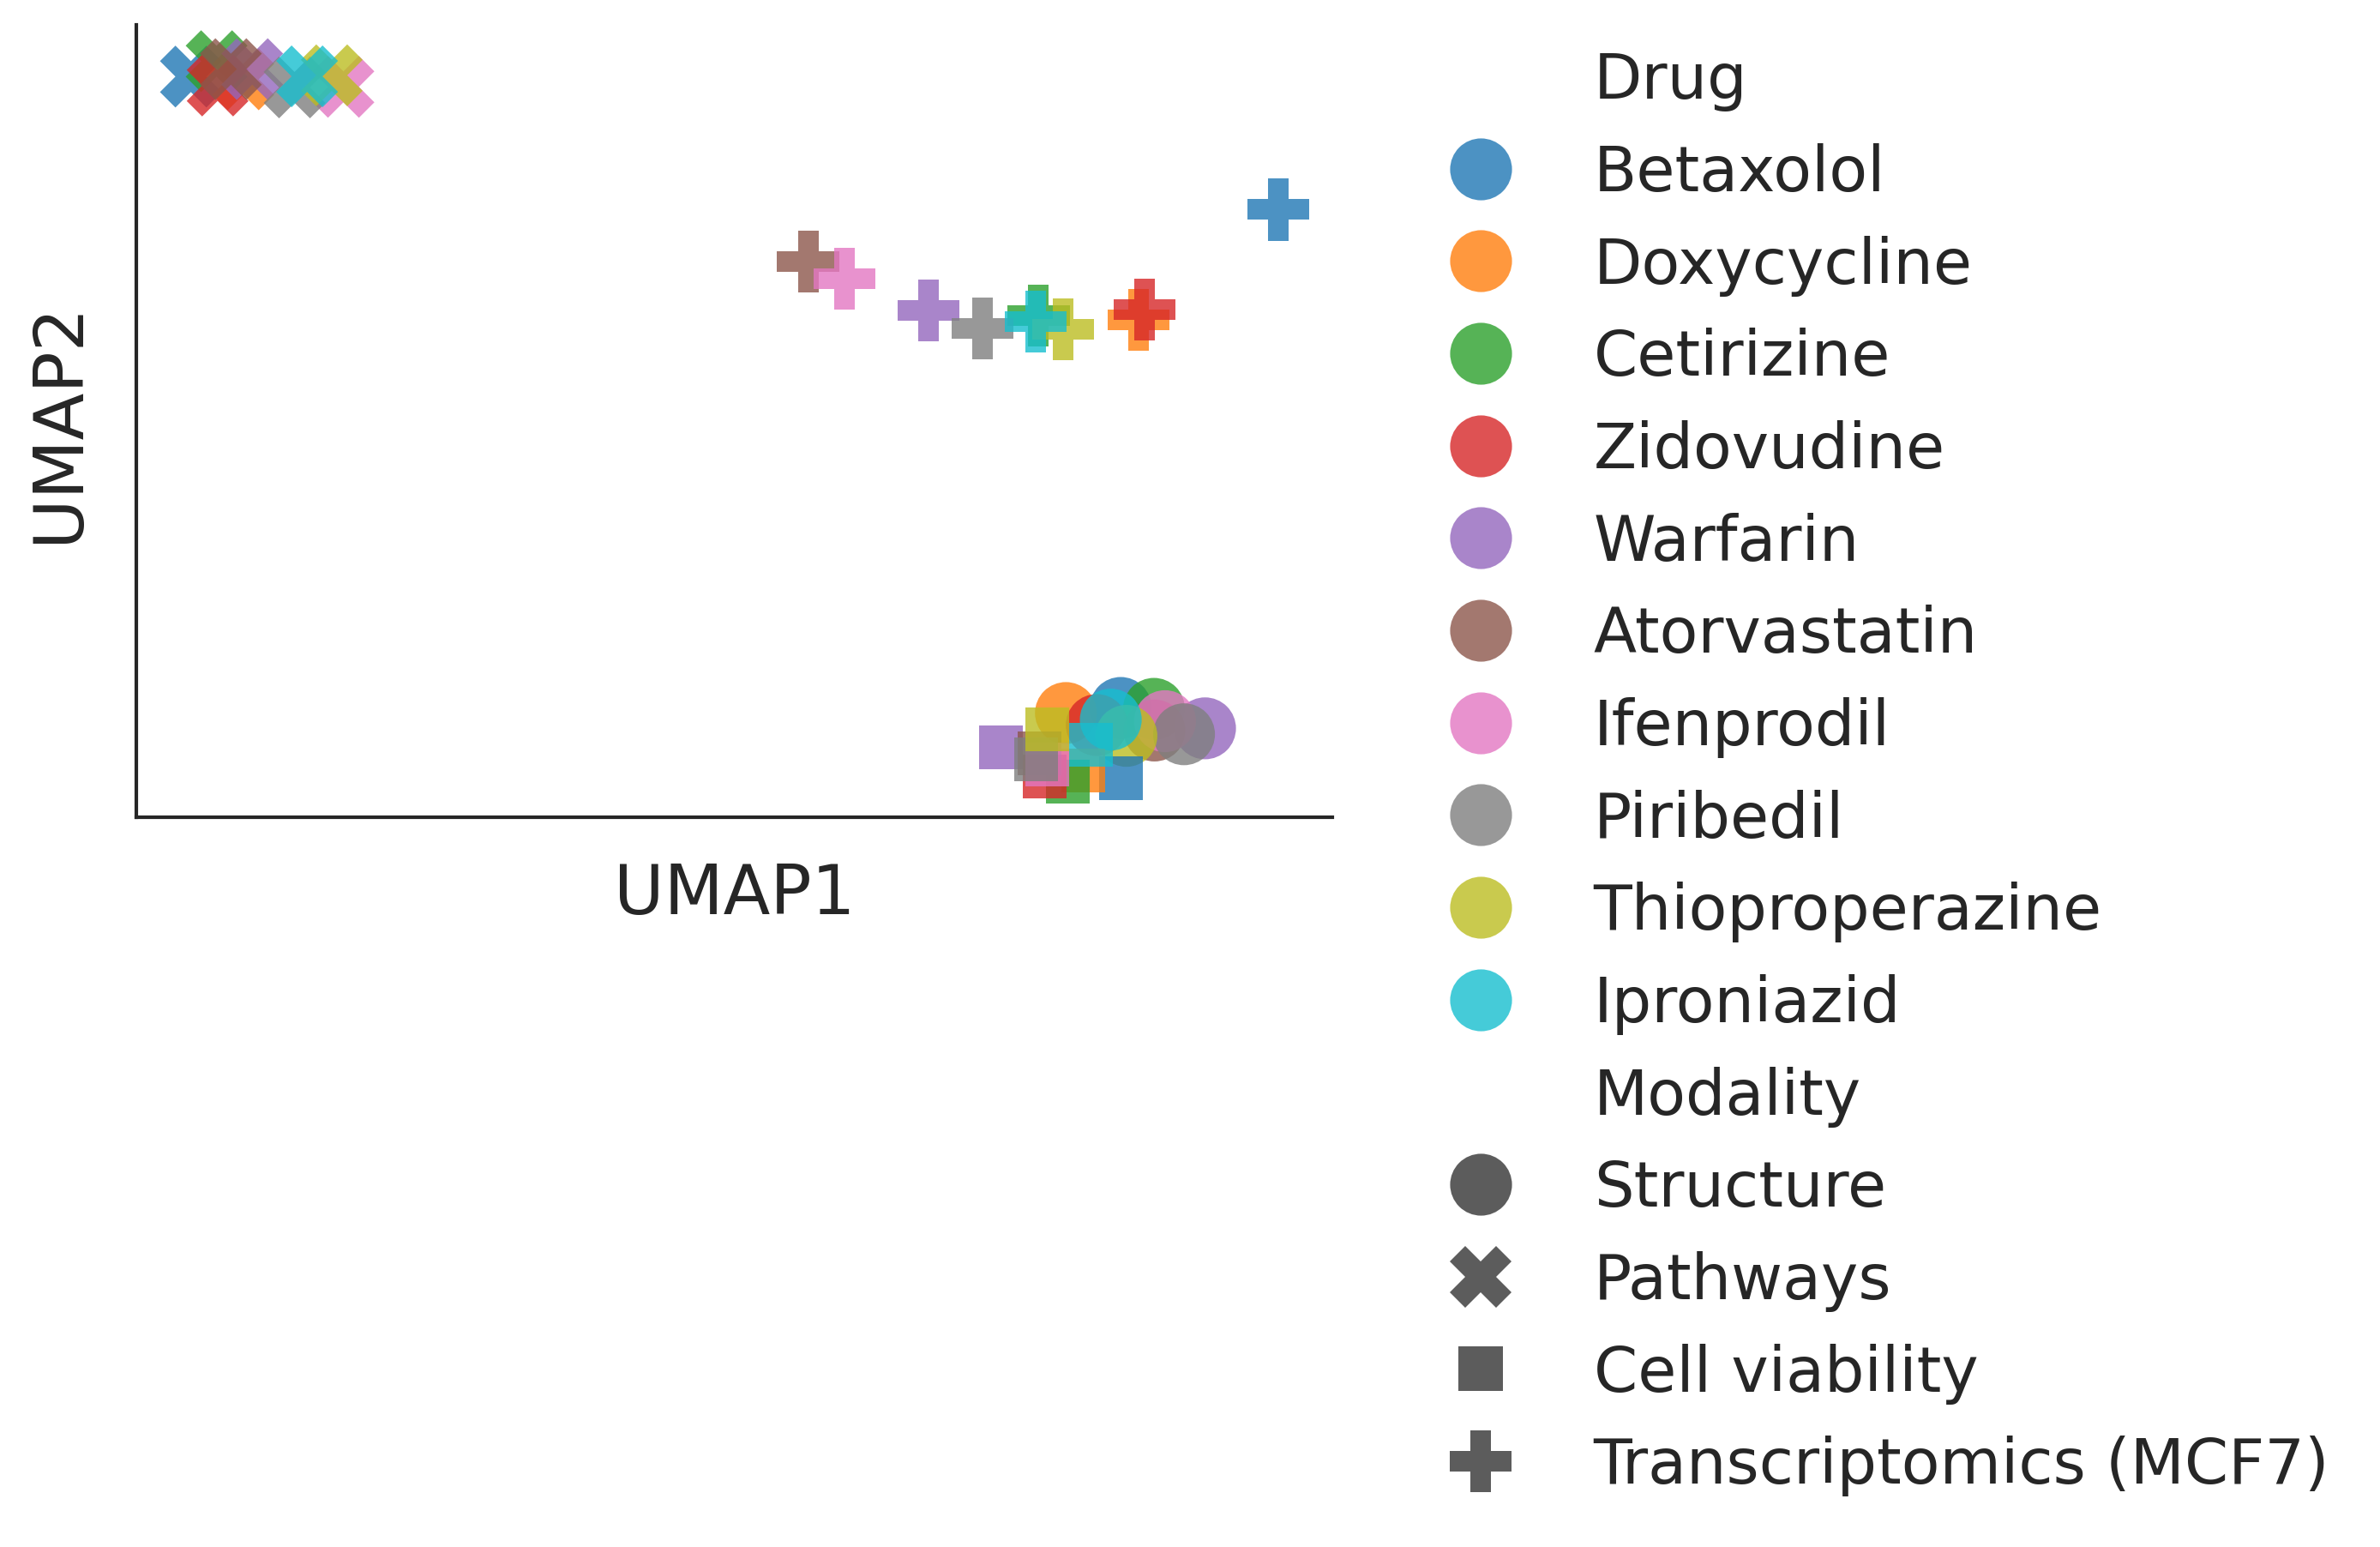

In [ ]:
samples_before_str_embeds = before_str['embeds'][np.isin(before_str['drugs'], drugs_of_interest), :].numpy()
samples_before_kg_embeds = before_kg['embeds'][np.isin(before_kg['drugs'], drugs_of_interest), :].numpy()
samples_before_cv_embeds = before_cv['embeds'][np.isin(before_cv['drugs'], drugs_of_interest), :].numpy()
samples_before_tx_mcf7_embeds = before_tx_mcf7['embeds'][np.isin(before_tx_mcf7['drugs'], drugs_of_interest), :].numpy()
samples_before_tx_pc3_embeds = before_tx_pc3['embeds'][np.isin(before_tx_pc3['drugs'], drugs_of_interest), :].numpy()
samples_before_tx_vcap_embeds = before_tx_vcap['embeds'][np.isin(before_tx_vcap['drugs'], drugs_of_interest), :].numpy()

all_samples_before_embeds = np.concatenate([
    samples_before_str_embeds,
    samples_before_kg_embeds,
    samples_before_cv_embeds,
    samples_before_tx_mcf7_embeds,
    samples_before_tx_pc3_embeds,
    samples_before_tx_vcap_embeds,
], axis=0)
umap_before = UMAP().fit_transform(all_samples_before_embeds)

# Create a DataFrame with umap_before, modality_labels, and drug_labels
plot_data = pd.DataFrame(umap_before, columns=['UMAP1', 'UMAP2'])
plot_data['Modality'] = modality_labels
plot_data['Drug'] = drug_labels

# Create scatter plot using seaborn
plt.figure(figsize=(6, 4), dpi=300)
sns.set(context="paper", style="white", font_scale=2)
ax = sns.scatterplot(data=plot_data[plot_data["Modality"].isin(['Structure', 'Pathways', 'Cell viability', 'Transcriptomics (MCF7)'])], 
                     x='UMAP1', y='UMAP2', hue='Drug', style='Modality', alpha=.8, s=300, linewidth=0, palette="tab10")

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False, ncols=1)
ax.set(xticklabels=[])
ax.set(yticklabels=[])
# ax.legend_.remove()
sns.despine()

plt.savefig("./fig1_drug_embeds_before_pretrain.svg", dpi=300, format="svg")
plt.show()